In [1]:
from collections import deque
from dataclasses import dataclass
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
input_small = """###############
#.......#....E#
#.#.###.#.###.#
#.....#.#...#.#
#.###.#####.#.#
#.#.#.......#.#
#.#.#####.###.#
#...........#.#
###.#.#####.#.#
#...#.....#.#.#
#.#.#.###.#.#.#
#.....#...#.#.#
#.###.#.#.#.#.#
#S..#.....#...#
###############"""

input_medium = """#################
#...#...#...#..E#
#.#.#.#.#.#.#.#.#
#.#.#.#...#...#.#
#.#.#.#.###.#.#.#
#...#.#.#.....#.#
#.#.#.#.#.#####.#
#.#...#.#.#.....#
#.#.#####.#.###.#
#.#.#.......#...#
#.#.###.#####.###
#.#.#...#.....#.#
#.#.#.#####.###.#
#.#.#.........#.#
#.#.#.#########.#
#S#.............#
#################"""

with open("input.txt", "r") as f:
    input_large = f.read()


def parse_input(input_: str):
    table = []
    start = None
    end = None
    for row, line in enumerate(input_.splitlines()):
        line = list(line.strip())
        if "S" in line:
            start = row, line.index("S")
        if "E" in line:
            end = row, line.index("E")
        table.append(line)
    return np.array(table), start, end


COST_TURN = 1000
COST_MOVE = 1


@dataclass
class State:
    pos: tuple[int, int]
    dir: Literal["<", ">", "^", "v"]

    def __hash__(self):
        return hash(self.pos) + hash(self.dir)


@dataclass
class StateScore:
    pos: tuple[int, int]
    dir: Literal["<", ">", "^", "v"]
    score: int = 0

    def __hash__(self):
        return hash(self.pos) + hash(self.dir)

    def get_state(self):
        return State(pos=self.pos, dir=self.dir)

    def get_score(self):
        return self.score


def positions_dic_to_array(maze: dict[tuple[int, int], float]) -> np.array:
    n_rows = max(x[0] for x in maze.keys()) + 1
    n_cols = max(x[1] for x in maze.keys()) + 1
    table = np.ones((n_rows, n_cols), dtype="float") * np.nan
    for pos, value in maze.items():
        if isinstance(value, (int, float)):
            table[pos] = value

    return table

## travelling from end to start populating best score per position

We use DP strategy: filling the minimum cost needed to go from each State (postion, dir)
to the end position.

From here, we can extract the information postion -> best score to get to the end.

Particularly, we can extract the optimal score to go from the initial state to the end.

Later, this will serve to extract the optimal paths.

In [14]:
def possible_states_scores(
    table, state: StateScore, end_to_start: bool = True
) -> list[StateScore]:
    next_states = []
    sign = -1 if end_to_start else 1
    dir_to_deltas = {">": (0, 1), "<": (0, -1), "^": (-1, 0), "v": (1, 0)}
    for new_dir, delta in dir_to_deltas.items():
        next_pos = state.pos[0] + sign * delta[0], state.pos[1] + sign * delta[1]
        is_in = (0 <= next_pos[0] < table.shape[0]) and (
            0 <= next_pos[1] < table.shape[1]
        )
        # print(f"next_pos: {next_pos}, is_out: {is_out}")
        if is_in and table[next_pos] != "#":
            # case when the state has no direction
            if state.dir is None:
                k = 0
            else:
                directions = {state.dir, new_dir}
                if len(directions) == 1:
                    k = 0
                # case when the state has opposite directions
                elif directions == {"<", ">"} or directions == {"^", "v"}:
                    k = 2
                    continue
                else:
                    k = 1
            new_score = state.score - sign * (COST_MOVE + k * COST_TURN)
            # when finding all paths, we only visit if the new score is better
            if end_to_start or new_score >= table[next_pos]:
                new_state = StateScore(pos=next_pos, dir=new_dir, score=new_score)
                next_states.append(new_state)
    return next_states


def travel_end_to_start(
    table: np.array,
    end: tuple[int, int],
) -> tuple[int, dict[State, float]]:
    """Populate the table with the optimal score to reach the end from each cell.

    Additionally, return the optimal score to reach the end from the start.

    Parameters
    ----------
    table : np.array
        Table with the maze, where "#" are walls, "S" is the start and "E" is the end.
    end : tuple[int, int]
        Position of the end in the table.

    Returns
    -------
    optimal_score: int
        Optimal score to reach the end from the start.
    state_to_score: dict[State, float]
        Dictionary with the optimal score to reach the end from each cell.
    """
    init_state = StateScore(pos=end, dir=None, score=0)
    TARGET_VALUE = "S"
    state_to_score: dict[State, float] = {}
    state_to_score[init_state.get_state()] = init_state.get_score()
    best_score = float("inf")
    # FIFO
    stack = deque([init_state])
    while len(stack) > 0:
        state = stack.popleft()
        if table[state.pos] == TARGET_VALUE:
            # the state at the start must have dir = ">"
            k = 0 if state.dir == ">" else 1
            state.score += COST_TURN * k
            best_score = min(best_score, state.get_score())
            continue
        else:
            next_states = possible_states_scores(table, state)
            for next_state in next_states:
                # prune: don't visit if the score is higher than the best score
                if next_state.get_score() > best_score:
                    continue
                elif next_state.get_state() in state_to_score:
                    if next_state.get_score() < state_to_score[next_state.get_state()]:
                        state_to_score[next_state.get_state()] = next_state.get_score()
                        stack.append(next_state)
                else:
                    state_to_score[next_state.get_state()] = next_state.get_score()
                    stack.append(next_state)

    return best_score, state_to_score

(139, 1) (1, 139)
optimal_score=93436


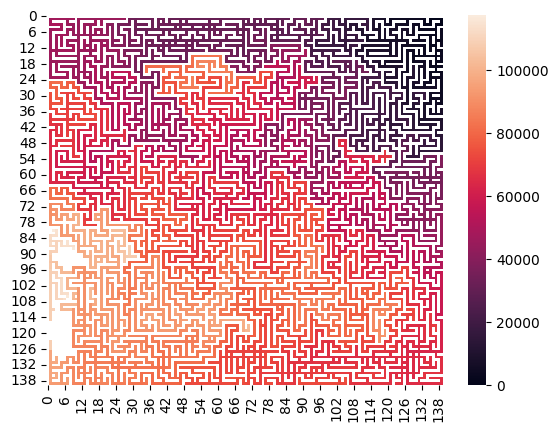

In [13]:
plot = True

table, start, end = parse_input(input_large)
print(start, end)
optimal_score, state_to_score = travel_end_to_start(table, end)
print(f"{optimal_score=}")

if plot:
    df_long = pd.DataFrame(
        [
            {"row": state.pos[0], "col": state.pos[1], "dir": state.dir, "score": score}
            for state, score in state_to_score.items()
        ]
    )
    df_long = df_long.groupby(["row", "col"])["score"].min().to_dict()
    array = positions_dic_to_array(df_long)

    sns.heatmap(array, annot=False, fmt=".0f", annot_kws={"fontsize": 7})

## Part 2: Optimal paths

Having the table with the best score to get to the end, we can now transverse 
the maze in reverse order (from start to end), only keeping possibilities
which are better than the optimal score.

(139, 1) (1, 139)
optimal_score=93436


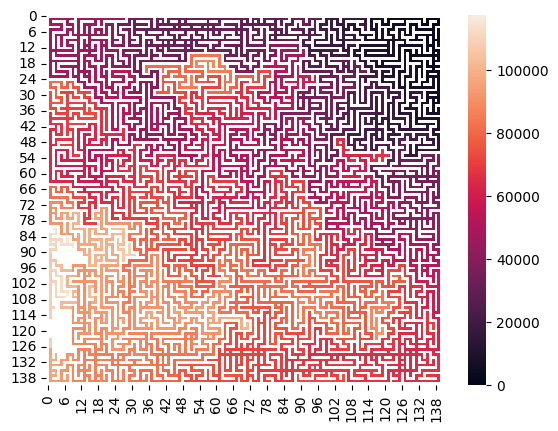

Visited places: 486


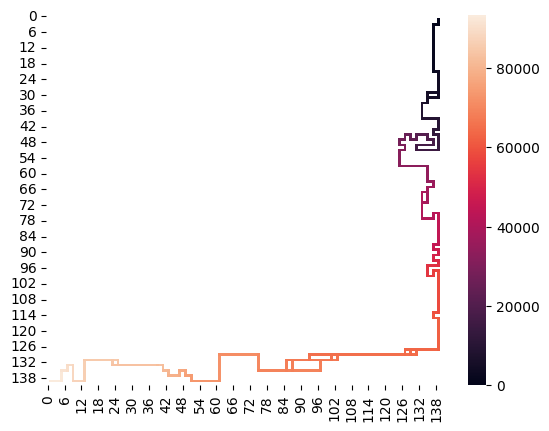

In [11]:
def descenting_path(array, start, optimal_score: int, verbose=False):
    stack = [StateScore(pos=start, dir=">", score=optimal_score)]
    visited_positions = set()
    while len(stack) > 0:
        state_score = stack.pop()
        visited_positions.add(state_score.pos)
        next_states = possible_states_scores(array, state_score, end_to_start=False)
        if verbose and len(next_states) > 1:
            print("Bifurcation found:")
            print(state_score, "->", next_states)
        stack.extend(next_states)
    return visited_positions


plot = True

table, start, end = parse_input(input_large)
print(start, end)
optimal_score, state_to_score = travel_end_to_start(table, end)
print(f"{optimal_score=}")

df_long = pd.DataFrame(
    [
        {"row": state.pos[0], "col": state.pos[1], "dir": state.dir, "score": score}
        for state, score in state_to_score.items()
    ]
)
df_long = df_long.groupby(["row", "col"])["score"].min().reset_index()
array = np.ones_like(table, dtype="float") * np.nan
for _, ser in df_long.iterrows():
    array[ser.row, ser.col] = ser.score

if plot:
    # print(array)
    sns.heatmap(array, annot=False, fmt=".0f", annot_kws={"fontsize": 7})
    plt.show()


visited_places = descenting_path(array, start, optimal_score)
n_visited = len(visited_places)
print("Visited places:", n_visited)

array = np.ones_like(table, dtype="float") * np.nan
for _, ser in df_long.iterrows():
    if (ser.row, ser.col) in visited_places:
        array[ser.row, ser.col] = ser.score
# array[table == "#"] = np.nan
if plot:
    # print(array)
    sns.heatmap(array, annot=False, fmt=".0f", annot_kws={"fontsize": 7})
